In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import networkx as nx
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib
from operator import itemgetter
from networkx.algorithms import bipartite
import torch as th
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

# Веб-скрейпинг

In [ ]:
# Получение первоночальных ссылок


list_science = ['social-and-economic-geography', 'environmental-biotechnology', 'economics-and-business',
                'agricultural-biotechnology', 'other-agricultural-sciences',
                'electrical-electronic-information-engineering', 'computer-and-information-sciences',
                'other-engineering-and-technologies', 'agriculture-forestry-and-fisheries',
                'industrial-biotechnology']
# list_science - список с названиями специальностей
list_url_stat_full = list()
for i in list_science:
    # Получаем начальную страницу каждой из специальностей
    url_ = f'https://cyberleninka.ru/article/c/{i}'
    doc_ = BeautifulSoup(requests.get(url_).text, "html.parser")
    # Конструкция try - except, для игнорирования капчи и пустого списка кода
    try:
        # Находим количество страниц
        range_int = int(doc_.find_all('ul', class_='paginator')[0].find_all('li')[-1].a['href'].split('/')[-1])
        for j in range(range_int):
            # Получаем код каждой страницы из специальностей
            url = f'https://cyberleninka.ru/article/c/{i}/{j + 1}'
            doc = BeautifulSoup(requests.get(url).text, "html.parser")
            try:
                # Получаем список статей со страницы и добавляем в список
                list_a = (doc.find_all('div', class_='full')[0]).find_all('ul', class_ = "list")[0].find_all('a')
                for u in list_a:
                    list_url_stat_full.append(u['href'])
            except IndexError:
                pass
    except IndexError:
        pass

In [ ]:
with open('list_url_stat_full.txt', "w", encoding="utf-8") as file:
    file.write(str(list_url_stat_full))

In [ ]:
len(list_url_stat_full)

65938

In [ ]:
# Получение подходящих ссылок


word_list = ['"умные" теплицы', 'умная теплица', 'умные теплицы', '"умная" теплица',
             'биоэкономика', 'биотехнология', 'bioeconomy', 'biotechnology', 'bio-economics',
             '«умные» теплицы', '«умная» теплица']
# word_list - список с ключевыми словами
answer_url_list_full = list()
for i in list_url_stat_full:
    # Получаем код веб-страницы статьи
    url = 'https://cyberleninka.ru/' + i
    doc = BeautifulSoup(requests.get(url).text, "html.parser")
    for j in word_list:
        try:
            # Проверяем налицие ключевого слова в тексте веб-страницы
            if j in (doc.find_all('div', class_ = 'main')[0]).text.lower():
                answer_url_list_full.append(i)
        except IndexError:
            pass

In [ ]:
# Получение полных данных

df = pd.DataFrame(columns=['название', 'специальность', 'просмотры', 'похожая статья'])

for i in answer_url_list_full:
    # Получаем код веб-страницы
    url = 'https://cyberleninka.ru/' + i
    doc_ = BeautifulSoup(requests.get(url).text, "html.parser")
    try:
        # Получаем значения имени, специальности и количества просмотров
        name = (doc_.find_all('div', class_ = 'main')[0]).h1.i.text
        nature = (doc_.find_all('div', class_ = 'main')[0]).h1.span.i.text
        viewing = int((doc_.find_all('div', class_ = 'main')[0]).find_all('div', class_ = 'statitem views')[0].text)
        doc_iv = doc_.find_all('div', class_ = 'infoblock visible')
        # Вытягиваем список статей с похожей темой
        if len(doc_iv) == 10:
            list_li = doc_iv[3].find_all('div', class_ = 'full')[0].ul.find_all('li')
            for j in list_li:
                li_text = j.div.text
                df.loc[len(df)] = [name, nature, viewing, li_text]
        elif len(doc_iv) == 9:
            list_li = doc_iv[2].find_all('div', class_ = 'full')[0].ul.find_all('li')
            for j in list_li:
                li_text = j.div.text
                df.loc[len(df)] = [name, nature, viewing, li_text]
    except IndexError:
        pass

In [ ]:
df.to_csv('df.csv')

# Создание графового набора данных

In [4]:
df = pd.read_csv('df.csv')

In [6]:
df

название  \
0     Технологические процессы отходообразования при...   
1     Технологические процессы отходообразования при...   
2     Технологические процессы отходообразования при...   
3     Технологические процессы отходообразования при...   
4     Технологические процессы отходообразования при...   
...                                                 ...   
7911         Экологизация процессов очистки шахтных вод   
7912         Экологизация процессов очистки шахтных вод   
7913         Экологизация процессов очистки шахтных вод   
7914         Экологизация процессов очистки шахтных вод   
7915         Экологизация процессов очистки шахтных вод   

                    специальность  просмотры  \
0     Экологические биотехнологии         62   
1     Экологические биотехнологии         62   
2     Экологические биотехнологии         62   
3     Экологические биотехнологии         62   
4     Экологические биотехнологии         62   
...                           ...        ...   
7911  Экологические биотехнологии        161   
7912  Экологические биотехнологии        161   
7913  Экологические биотехнологии        161   
7914  Экологические биотехнологии        161   
7915  Экологические биотехнологии        161   

                                         похожая статья  
0     Оценка методов очистки сточных вод от соединен...  
1     Процессы биотрансформации азота в технологиях ...  
2     Некоторые аспекты водоснабжения и охраны гидро...  
3     Биогеохимические барьеры для ремедиации почв и...  
4     Физикохимические методы снижения агрессивности...  
...                                                 ...  
7911  Очистка шахтных вод от нефтемаслопримесей и вз...  
7912         Биохимический способ очистки карьерных вод  
7913  Влияние горных предприятий на экологическую об...  
7914  Учет водного фактора при разработке месторожде...  
7915  Эколого-биотехнологические направления утилиза...  

[7916 rows x 4 columns]

In [ ]:
G = nx.DiGraph()

# Создаём узлы из столбца название и добавляем атрибуты
for idx, row in df.iterrows():
    G.add_node(row['название'], специальность = row['специальность'], просмотры = row['просмотры'])

# Создаём узлы с похожими статьями
for similar_article in df['похожая статья'].unique():
    G.add_node(similar_article)

# Создаём связи между узлами
for idx, row in df.iterrows():
    G.add_edge(row['название'], row['похожая статья'])

In [ ]:
len(G.nodes())

8224

## Граф G

In [ ]:
dict(sorted(Counter(df['похожая статья']).items(), key = itemgetter(1), reverse=True))

{'Некоторые аспекты водоснабжения и охраны гидросферы от загрязнения (по опыту научно-инженерного центра «Потенциал-2»)': 15,
 'Технологические подходы к детоксикации и биовосстановлению нефтезагрязнённых земель': 10,
 'Анализ технических решений извлечения тяжелых металлов из гетерогенных отходов систем водоотведения': 8,
 'Совершенствование биологических очистных сооружений города Красновишерска': 8,
 'Эффективность работы очистных сооружений 5-го канализационного бассейна г. Прокопьевска': 6,
 'Биодеградация нефтезагрязнения черноземов Краснодарского края микробными препаратами': 6,
 'Биодеструкция нефти отдельными штаммами и принципы составления микробных консорциумов для очистки окружающей среды от углеводородов нефти': 6,
 'Предозонирование – как средство интенсификации процессов биологической очистки сточных вод': 6,
 'Содержание тяжелых металлов в почвенном покрове, листьях березы под воздействием промышленности г. Красноярска': 5,
 'Ассоциации углеводородокисляющих микрооргани

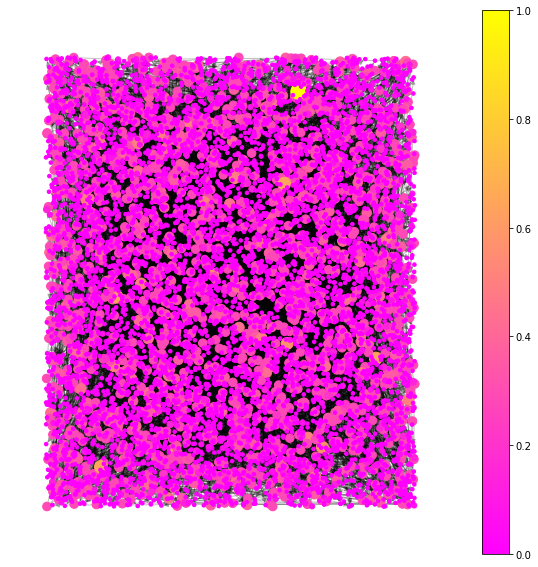

In [ ]:
fig, axes = plt.subplots(1, 1, figsize = (10, 10))
list_degree = list(dict(G.degree()).values())
nx.draw_networkx(G, pos = nx.random_layout(G), node_size = (np.array(list_degree) * 10) ** 1.1, node_color = list_degree, cmap = 'spring', edge_color = (0, 0, 0, 0.25), with_labels = False)
plt.colorbar(plt.cm.ScalarMappable(cmap = plt.cm.spring), ax = plt.gca());
plt.box(False);

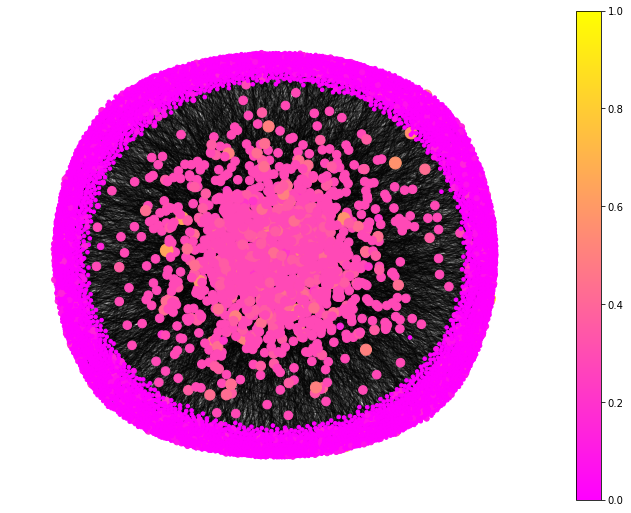

In [ ]:
fig, axes = plt.subplots(1, 1, figsize = (12, 9))
list_degree = list(dict(G.degree()).values())
nx.draw_networkx(G, pos = nx.spring_layout(G), node_size = (np.array(list_degree) * 10) ** 1.1, node_color = list_degree, cmap = 'spring', edge_color = (0, 0, 0, 0.25), with_labels = False)
plt.colorbar(plt.cm.ScalarMappable(cmap = plt.cm.spring), ax = plt.gca());
plt.box(False);

In [ ]:
G.number_of_nodes(), G.number_of_edges()

(8224, 7916)

Text(0.5, 0, 'Степень узла')

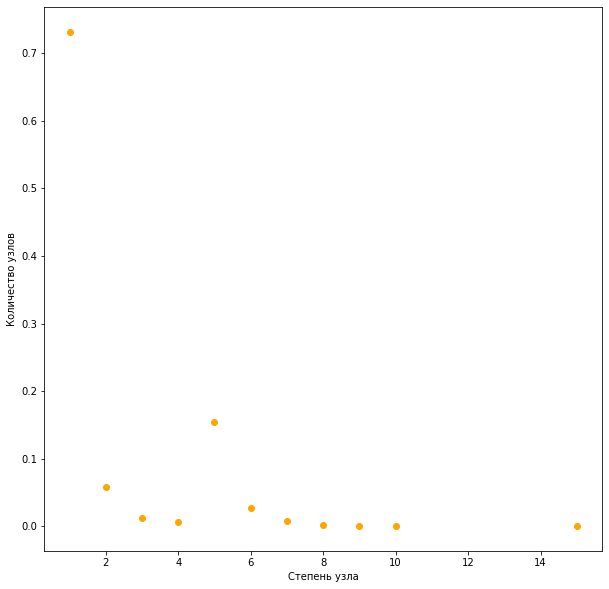

In [ ]:
# Рассчёт степеней
degree_list = [v for k, v in G.degree]
degree_df = pd.Series(degree_list).value_counts() / len(G)
degree_df.to_frame()
degree_df = degree_df.reset_index()

# Визуализация в обычных шкалах
plt.figure(figsize = (10, 10))
plt.xscale('linear')
plt.yscale('linear')
plt.scatter(x = degree_df['index'], y = degree_df[0], color = 'orange')
plt.ylabel('Количество узлов')
plt.xlabel('Степень узла')


Text(0.5, 0, 'Степень узла, log')

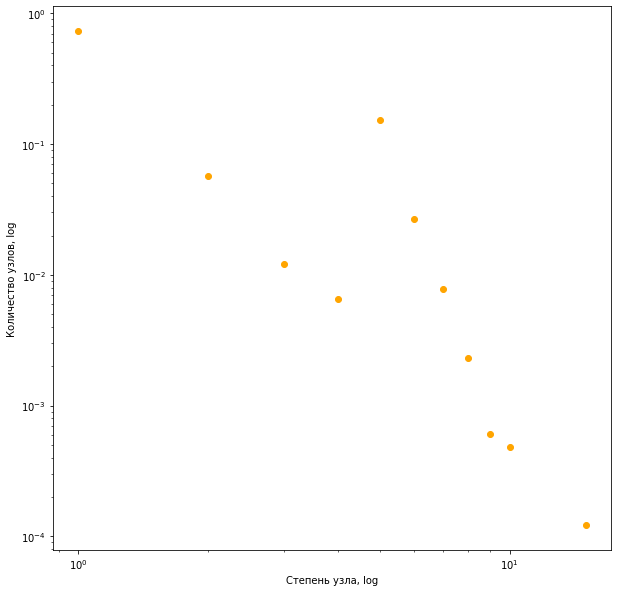

In [ ]:
# Визуализация в логорифмических шкалах
plt.figure(figsize = (10, 10))
plt.scatter(x = degree_df['index'], y = degree_df[0], color = 'orange')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Количество узлов, log')
plt.xlabel('Степень узла, log')

In [ ]:
nx.density(G)

0.00011705565342725231

In [ ]:
dict_att = dict(G.nodes(data = 'специальность'))

In [ ]:
color_list_my = list()
att_list = list(set(dict_att.values()))
for i in dict_att:
    for j in range(len(att_list)):
        if dict_att[i] == att_list[j]:
            color_list_my.append(j)

len(G.nodes()), len(color_list_my)

(8224, 8224)

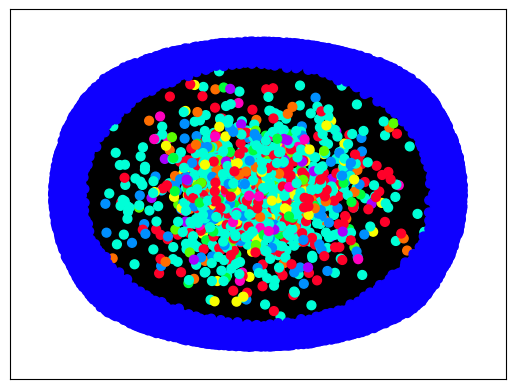

In [ ]:
nx.draw_networkx(G, pos = nx.spring_layout(G), node_color = color_list_my, cmap = 'gist_rainbow', node_size = 40, with_labels = False)

<ipython-input-7-d75d2921fb65>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmapsp = matplotlib.cm.get_cmap('gist_rainbow')


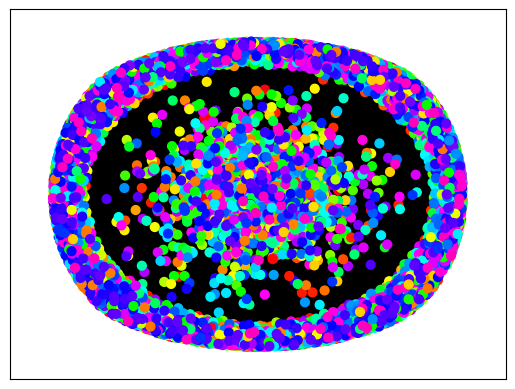

In [ ]:
comms = nx.community.louvain_communities(G, seed = 121)
cmapsp = matplotlib.cm.get_cmap('gist_rainbow')
list_color_i = np.linspace(0, 1, len(comms))

color_list_node = list()
for i in G.nodes():
    for j in range(len(comms)):
        if i in comms[j]:
            color_list_node.append(cmapsp(list_color_i[j]))


nx.draw_networkx(G, pos = nx.spring_layout(G), node_color = color_list_node, node_size = 40, with_labels = False)

In [ ]:
print("модулярность: ", nx.community.modularity(G, list(comms)))
print("покрытие: ", nx.community.partition_quality(G, list(comms))[0])
print("эффективность: ", nx.community.partition_quality(G, list(comms))[1])

модулярность:  0.9867741528596913
покрытие:  0.9929257200606367
эффективность:  0.9959341052973273


In [ ]:
class GCNLayer(nn.Module):
    def __init__(self, n_inputs: int, n_outputs: int, activation: None) -> None:
        super().__init__()

        # self.W - веса слоя
        W = th.empty(n_inputs, n_outputs, dtype=th.float32)
        nn.init.xavier_uniform_(W)
        self.W = nn.Parameter(W, requires_grad=True)

        # self.activation - функция активации, применяется после рассылки сообщений, может отсутствовать
        self.activation = activation

    def normalize_matrix(self, A: th.Tensor) -> th.Tensor:
        """A - исходная матрица смежности графа"""
        D = (th.linalg.inv(th.diag(th.sum(A, axis=1))))
        A = (D @ A)
        return A


    def forward(self, A: th.Tensor, X: th.Tensor) -> th.Tensor:
        """A - исходная матрица смежности графа
        X - матрица признаков узлов
        """
        A_norm = self.normalize_matrix(A)
        X_new = A_norm @ X @ self.W

        if self.activation is not None:
            X_new = self.activation(X_new)

        return X_new

In [ ]:
class GCN(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(n_inputs, 2, activation = th.tanh)
        self.gcn2 = GCNLayer(2, n_outputs, activation = None)

    def forward(self, A, X):
        X = self.gcn1(A, X)
        X = self.gcn2(A, X)
        return X

In [ ]:
A = th.Tensor(nx.adjacency_matrix(G, weight = None).toarray())

degrees = th.Tensor([G.degree(i) for i in G.nodes()])

In [ ]:
E_d = th.eye(A.shape[0])
E_d.diagonal(dim1 = -2, dim2 = -1).copy_(degrees)
E_d

tensor([[5., 0., 0.,  ..., 0., 0., 0.],
        [0., 5., 0.,  ..., 0., 0., 0.],
        [0., 0., 5.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [ ]:
(nx.adjacency_matrix(G, weight = None).toarray())

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
model = GCN(A.shape[0], 10)
optimizer = th.optim.Adam(model.parameters(), lr = 10e-3)
criterion = nn.CrossEntropyLoss()

In [ ]:
f = color_list_my
labels = th.Tensor(f)

In [ ]:
for epoch in range(30):
    optimizer.zero_grad()
    out = model(A, E_d)
    loss = criterion(out, labels.long())
    loss.backward()
    optimizer.step()

In [ ]:
model.gcn1(A, E_d)

tensor([[-0.3221, -0.4079],
        [-0.0532, -0.0552],
        [-0.0518, -0.0387],
        ...,
        [-0.3623, -0.2309],
        [-0.3623, -0.2309],
        [-0.3623, -0.2309]], grad_fn=<TanhBackward0>)

In [ ]:
X_new = model.gcn1(A, E_d).detach()
pos = dict(zip(G.nodes(), X_new))

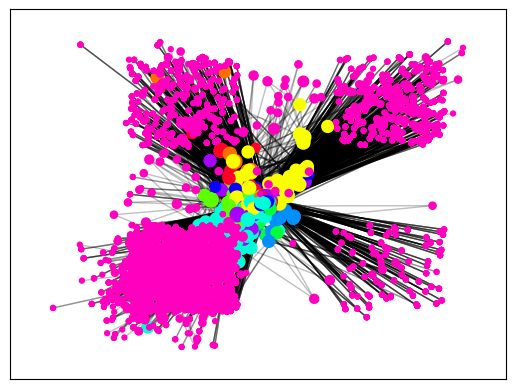

In [ ]:
list_degree = list(dict(G.degree()).values())
nx.draw_networkx(G, pos = pos, node_color = f, cmap = 'gist_rainbow',  node_size = (np.array(list_degree) * 10) ** 1.1, edge_color = (0, 0, 0, 0.25), with_labels = False)

In [ ]:
betweenness_centrality = nx.betweenness_centrality(G)

In [ ]:
sorted_values = sorted(betweenness_centrality.values(), reverse=True)
sorted_betweenness_centrality = dict()

for i in sorted_values:
    for k in betweenness_centrality.keys():
        if betweenness_centrality[k] == i:
            sorted_betweenness_centrality[k] = betweenness_centrality[k]

sorted_betweenness_centrality

{'Некоторые аспекты водоснабжения и охраны гидросферы от загрязнения (по опыту научно-инженерного центра «Потенциал-2»)': 0.01204510780358418,
 'Технологические подходы к детоксикации и биовосстановлению нефтезагрязнённых земель': 0.00935129532621682,
 'Технологические процессы отходообразования при биологической очистке': 0.008539932209132161,
 'Использование аборигенной микрофлоры для борьбы с нефтяным загрязнением подземных вод': 0.008051516480077195,
 'Биогеохимические барьеры для ремедиации почв и очистки почвенно-грунтовых вод': 0.007873636419330882,
 'Комплексная рекультивация территории Павельцевской нефтебазы': 0.006509943480649938,
 'Тяжелые металлы как фактор загрязнения окружающей среды (обзор литературы)': 0.005558707273788695,
 'Содержание тяжелых металлов в почве г. Челябинска': 0.005494540399304774,
 'Современные технологии очистки и восстановления земель, загрязненных нефтью и нефтепродуктами': 0.005377023428952283,
 'Экологическая оценка урбаноземов на примере террито

In [ ]:
closeness_centrality = nx.closeness_centrality(G)

In [ ]:
sorted_values = sorted(closeness_centrality.values(), reverse=True)
sorted_closeness_centrality = dict()

for i in sorted_values:
    for k in closeness_centrality.keys():
        if closeness_centrality[k] == i:
            sorted_closeness_centrality[k] = closeness_centrality[k]

sorted_closeness_centrality

{'Некоторые аспекты водоснабжения и охраны гидросферы от загрязнения (по опыту научно-инженерного центра «Потенциал-2»)': 0.021643216933853, 'Технологические процессы отходообразования при биологической очистке': 0.021510056303351104, 'Технологические подходы к детоксикации и биовосстановлению нефтезагрязнённых земель': 0.021357834892385637, 'Биогеохимические барьеры для ремедиации почв и очистки почвенно-грунтовых вод': 0.021193750931865537, 'Использование аборигенной микрофлоры для борьбы с нефтяным загрязнением подземных вод': 0.020964738127163315, 'Физикохимические методы снижения агрессивности отработанных электролитов путем перевода Cr (VI) в Cr (III)': 0.02087303211419352, 'Современные технологии очистки и восстановления земель, загрязненных нефтью и нефтепродуктами': 0.02081152144019637, 'Комплексная рекультивация территории Павельцевской нефтебазы': 0.0206219169699125, 'Нефтезагрязнённые серобурые почвы Апшеронского полуострова и методы их биорекультивации': 0.0204677187732327

In [ ]:
degree_centrality = nx.degree_centrality(G)

In [ ]:
sorted_values = sorted(degree_centrality.values(), reverse=True)
sorted_degree_centrality = dict()

for i in sorted_values:
    for k in degree_centrality.keys():
        if degree_centrality[k] == i:
            sorted_degree_centrality[k] = degree_centrality[k]

sorted_degree_centrality

{'Некоторые аспекты водоснабжения и охраны гидросферы от загрязнения (по опыту научно-инженерного центра «Потенциал-2»)': 0.0018241517694272164, 'Технологические подходы к детоксикации и биовосстановлению нефтезагрязнённых земель': 0.0012161011796181442, 'Ассоциации углеводородокисляющих микроорганизмов для биоремедиации нефтезагрязненных почв': 0.0010944910616563297, 'Использование микробного препарата для рекультивации нефтезагрязненной почвы различных типов': 0.0010944910616563297, 'Микроорганизмы-деструкторы ПАВ в водных средах': 0.0009728809436945154, 'Методология и показатели санитарно-микробиологического контроля безопасности почвы (аналитический обзор)': 0.0009728809436945154, 'Биоремедиация нарушенных углеводородами и тяжелыми металлами почв с использованием Rhodococcus-биосурфактантов и иммобилизованных родококков': 0.0009728809436945154, 'Анализ технических решений извлечения тяжелых металлов из гетерогенных отходов систем водоотведения': 0.0009728809436945154, 'Совершенство

## Граф В

In [7]:
df_b = df[['название', 'специальность', 'просмотры']]
df_b = df_b.drop_duplicates()

In [ ]:
# Создание двудольного графа специальностей и статей
B = nx.Graph()
B.add_nodes_from(df_b['название'], просмотры = df_b['просмотры'], bipartite = 0)
B.add_nodes_from(df_b['специальность'], bipartite = 1)
for idx, row in df_b.iterrows():
    B.add_edge(row['специальность'], row['название'])

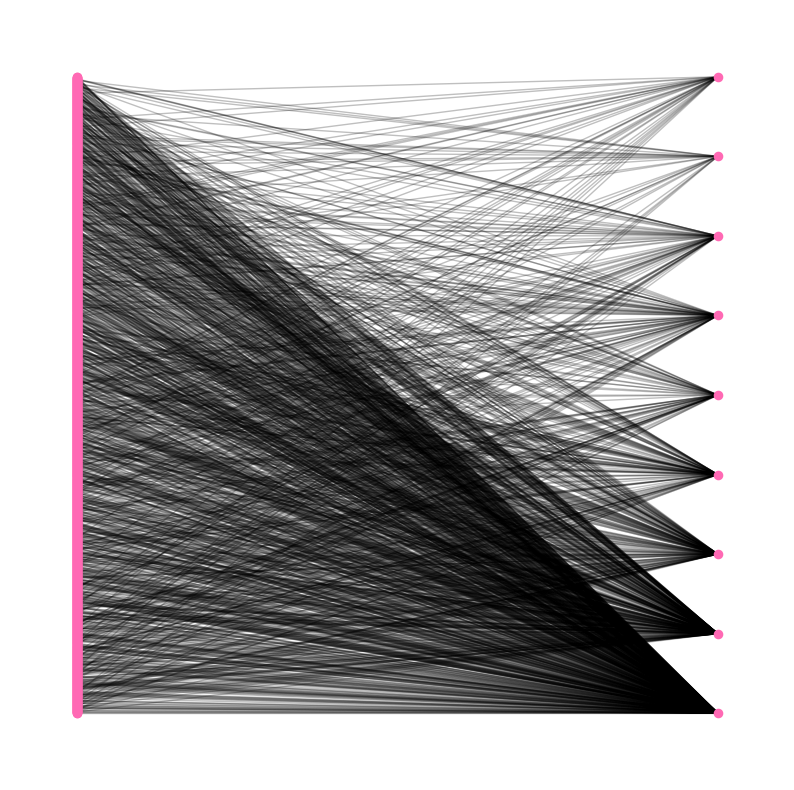

In [ ]:
fig, axes = plt.subplots(1, 1, figsize = (10, 10))

# Разбиение узла на сообщества специальностей и статей
top_nodes = [n for n, d in B.nodes(data=True) if d.get('bipartite') == 0]
bottom_nodes = [n for n, d in B.nodes(data=True) if d.get('bipartite') == 1]

pos = nx.bipartite_layout(B, top_nodes)

nx.draw(B, pos, node_size = 35, edge_color = (0, 0, 0, 0.25), node_color = 'hotpink')
plt.show()

In [ ]:
B.number_of_nodes(), B.number_of_edges()

(1599, 1590)

In [ ]:
dict(sorted(Counter(df_b['специальность']).items(), key = itemgetter(1), reverse=True))

{'Экологические биотехнологии': 725,
 'Сельское хозяйство, лесное хозяйство, рыбное хозяйство': 343,
 'Прочие сельскохозяйственные науки': 158,
 'Агробиотехнологии': 107,
 'Экономика и бизнес': 77,
 'Социальная и экономическая география': 62,
 'Прочие технологии': 59,
 'Электротехника, электронная техника, информационные технологии': 34,
 'Компьютерные и информационные науки': 25}

In [ ]:
list_spec = list(np.unique(df_b['специальность']))

dict_atth = dict(G.nodes(data = True))
dict_spech = {'Экологические биотехнологии': (None, 0),
 'Сельское хозяйство, лесное хозяйство, рыбное хозяйство':  (None, 0),
 'Прочие сельскохозяйственные науки':  (None, 0),
 'Агробиотехнологии':  (None, 0),
 'Социальная и экономическая география':  (None, 0),
 'Экономика и бизнес':  (None, 0),
 'Прочие технологии':  (None, 0),
 'Компьютерные и информационные науки':  (None, 0),
 'Электротехника, электронная техника, информационные технологии':  (None, 0)}
for i in dict_atth:
    if dict_atth[i] != {}:
        if dict_atth[i]['просмотры'] > dict_spech[dict_atth[i]['специальность']][1]:
            dict_spech[dict_atth[i]['специальность']] = (i, dict_atth[i]['просмотры'])

dict_spech

{'Экологические биотехнологии': ('Основы гигиенического нормирования факторов окружающей среды (избранные лекции по общей гигиене)',
  15488),
 'Сельское хозяйство, лесное хозяйство, рыбное хозяйство': ('Экологические проблемы в сельском хозяйстве как следствие интенсификации развития агропромышленного комплекса России',
  17711),
 'Прочие сельскохозяйственные науки': ('Применение СВЧ-нагрева в пищевой промышленности и общественном питании',
  9072),
 'Агробиотехнологии': ('Использование трансгенных животных в биотехнологии: перспективы и проблемы',
  9433),
 'Социальная и экономическая география': ('Суть, проблемы и задачи развития биоэкономики в Украине',
  4231),
 'Экономика и бизнес': ('США - абсолютный лидер мирового фармрынка', 11817),
 'Прочие технологии': ('Исследование качества и безопасности свинины', 3170),
 'Компьютерные и информационные науки': ('Hi-Tech: динамика взаимодействий науки и образования',
  1246),
 'Электротехника, электронная техника, информационные технологии

In [ ]:
bipartite.is_bipartite(B)

True

In [ ]:
degree_x, degree_y = bipartite.degrees(B, top_nodes)

Text(0.5, 0, 'Степень узла')

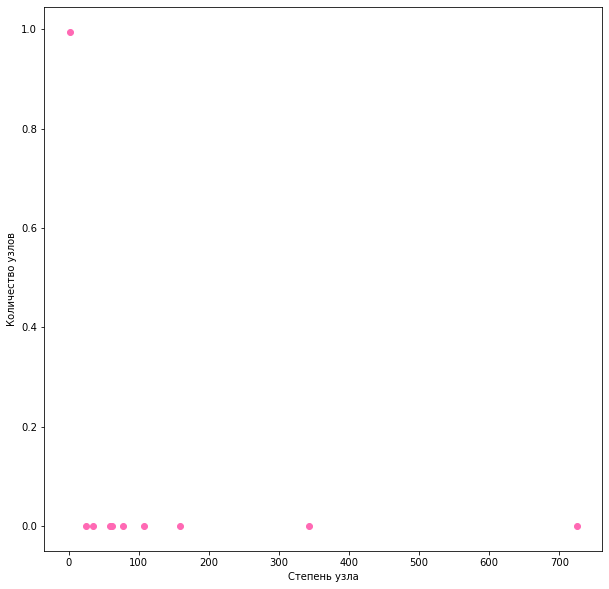

In [ ]:
# Рассчёт степеней
degree_list = [v for k, v in B.degree]
degree_df = pd.Series(degree_list).value_counts() / len(B)
degree_df.to_frame()
degree_df = degree_df.reset_index()

# Визуализация в обычных шкалах
plt.figure(figsize = (10, 10))
plt.xscale('linear')
plt.yscale('linear')
plt.scatter(x = degree_df['index'], y = degree_df[0], color = 'hotpink')
plt.ylabel('Количество узлов')
plt.xlabel('Степень узла')

Text(0.5, 0, 'Степень узла, log')

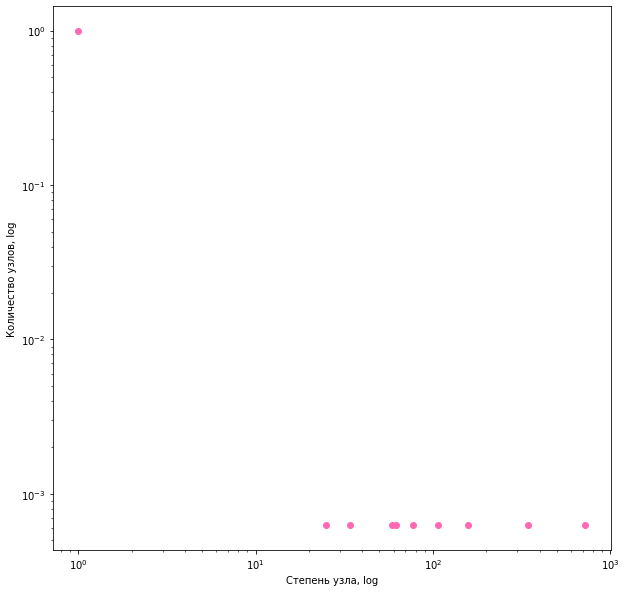

In [ ]:
plt.figure(figsize = (10, 10))
plt.scatter(x = degree_df['index'], y = degree_df[0], color = 'hotpink')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Количество узлов, log')
plt.xlabel('Степень узла, log')

In [ ]:
B_ = bipartite.projected_graph(B, bottom_nodes)

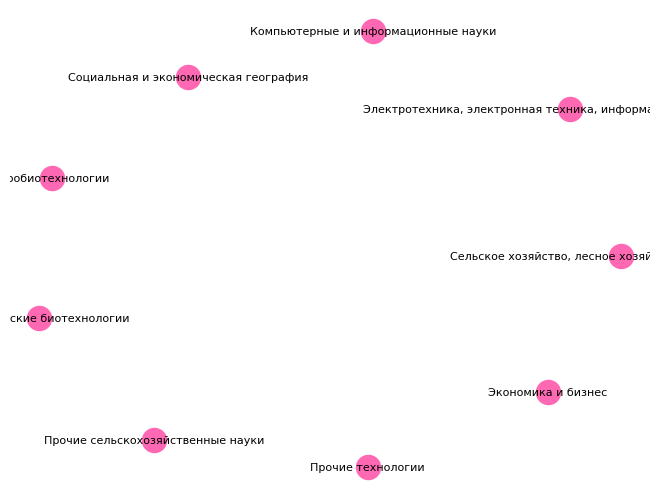

In [ ]:
nx.draw(B_, with_labels = True, font_size = 8, node_color = 'hotpink')

In [ ]:
dict_att = dict(B.nodes(data = 'специальность'))

color_list_my = list()
att_list = list(set(dict_att.values()))
for i in dict_att:
    for j in range(len(att_list)):
        if dict_att[i] == att_list[j]:
            color_list_my.append(j)

len(B.nodes()), len(color_list_my)

(1599, 1599)

<ipython-input-18-3aba600c684b>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmapsp = matplotlib.cm.get_cmap('gist_rainbow')


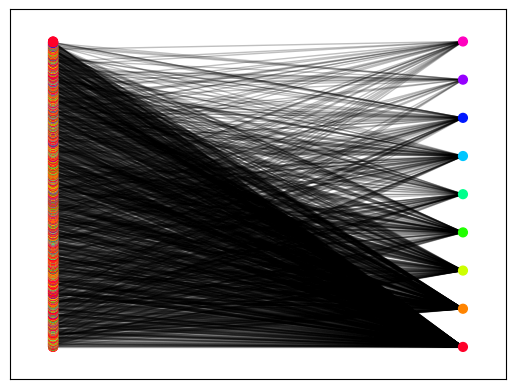

In [ ]:
import matplotlib

comms = nx.community.louvain_communities(B, seed = 121)
cmapsp = matplotlib.cm.get_cmap('gist_rainbow')
list_color_i = np.linspace(0, 1, len(comms))

color_list_node = list()
for i in B.nodes():
    for j in range(len(comms)):
        if i in comms[j]:
            color_list_node.append(cmapsp(list_color_i[j]))


nx.draw_networkx(B, pos, node_color = color_list_node, node_size = 40, edge_color = (0, 0, 0, 0.25), with_labels = False)

In [ ]:
print("модулярность: ", nx.community.modularity(B, list(comms)))
print("покрытие: ", nx.community.partition_quality(B, list(comms))[0])
print("эффективность: ", nx.community.partition_quality(B, list(comms))[1])

модулярность:  0.7251999525335232
покрытие:  1.0
эффективность:  0.7287369061232732


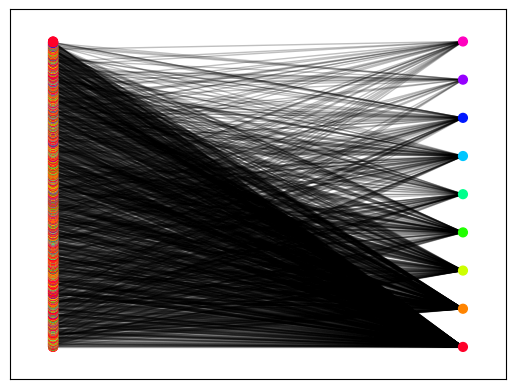

In [ ]:
comms_ = list(nx.community.label_propagation_communities(B))
list_color_i = np.linspace(0, 1, len(comms_))

color_list_node = list()
for i in B.nodes():
    for j in range(len(comms_)):
        if i in comms_[j]:
            color_list_node.append(cmapsp(list_color_i[j]))


nx.draw_networkx(B, pos, node_color = color_list_node, node_size = 40, edge_color = (0, 0, 0, 0.25), with_labels = False)

In [ ]:
print("модулярность: ", nx.community.modularity(B, list(comms_)))
print("покрытие: ", nx.community.partition_quality(B, list(comms_))[0])
print("эффективность: ", nx.community.partition_quality(B, list(comms_))[1])

модулярность:  0.7251999525335232
покрытие:  1.0
эффективность:  0.7287369061232732


In [ ]:
nx.density(B)

0.001244520002723855

In [ ]:
betweenness_centrality = nx.betweenness_centrality(B)

In [ ]:
sorted_values = sorted(betweenness_centrality.values(), reverse=True)
sorted_betweenness_centrality = dict()

for i in sorted_values:
    for k in betweenness_centrality.keys():
        if betweenness_centrality[k] == i:
            sorted_betweenness_centrality[k] = betweenness_centrality[k]

sorted_betweenness_centrality

{'Экологические биотехнологии': 0.20568133460501267,
 'Сельское хозяйство, лесное хозяйство, рыбное хозяйство': 0.0459661928694525,
 'Прочие сельскохозяйственные науки': 0.009720196582609916,
 'Агробиотехнологии': 0.004444346917679661,
 'Экономика и бизнес': 0.0022930980569794896,
 'Социальная и экономическая география': 0.0014819714373712288,
 'Прочие технологии': 0.0013409059383089224,
 'Электротехника, электронная техника, информационные технологии': 0.0004396541387441879,
 'Компьютерные и информационные науки': 0.0002351091651038438,
 'Технологические процессы отходообразования при биологической очистке': 0.0,
 'САНИТАРНО-ГИГИЕНИЧЕСКАЯ ОЦЕНКА РАБОТЫ СООРУЖЕНИЙ ПО ОЧИСТКЕ ШАХТНЫХ ВОД': 0.0,
 'ПОВЫШЕНИЕ КАЧЕСТВА ОЧИСТКИ КОРНЕПЛОДОВ САХАРНОЙ СВЁКЛЫ ПЕРЕД ЕЁ ПЕРЕРАБОТКОЙ': 0.0,
 'Исследования влияния содержания растительных добавок на показатели качества пряников': 0.0,
 'Характеристика почвенно-растительного покрова экосистем Калининградского полуострова': 0.0,
 'Роль и место аграрной

In [ ]:
closeness_centrality = nx.closeness_centrality(B)

In [ ]:
sorted_values = sorted(closeness_centrality.values(), reverse=True)
sorted_closeness_centrality = dict()

for i in sorted_values:
    for k in closeness_centrality.keys():
        if closeness_centrality[k] == i:
            sorted_closeness_centrality[k] = closeness_centrality[k]

sorted_closeness_centrality

{'Экологические биотехнологии': 0.45369211514392993,
 'Технологические процессы отходообразования при биологической очистке': 0.22700261109685935,
 'САНИТАРНО-ГИГИЕНИЧЕСКАЯ ОЦЕНКА РАБОТЫ СООРУЖЕНИЙ ПО ОЧИСТКЕ ШАХТНЫХ ВОД': 0.22700261109685935,
 'ПОВЫШЕНИЕ КАЧЕСТВА ОЧИСТКИ КОРНЕПЛОДОВ САХАРНОЙ СВЁКЛЫ ПЕРЕД ЕЁ ПЕРЕРАБОТКОЙ': 0.22700261109685935,
 'Характеристика почвенно-растительного покрова экосистем Калининградского полуострова': 0.22700261109685935,
 'Обоснование эколого-экономической эффективности природоохранной деятельности в строительном производстве': 0.22700261109685935,
 'Содержание тяжелых металлов в почве г. Челябинска': 0.22700261109685935,
 'Влияние изоэлектрической точки на процесс очистки сточных вод птицефабрик': 0.22700261109685935,
 'Нормирование содержания тяжёлых металлов в почве': 0.22700261109685935,
 'Дослідження процесів очищення побутових стоків від органічних сполук': 0.22700261109685935,
 'Экологизация экономики путь к устойчивому развитию': 0.227002611096859

In [ ]:
degree_centrality = nx.degree_centrality(B)

In [ ]:
sorted_values = sorted(degree_centrality.values(), reverse=True)
sorted_degree_centrality = dict()

for i in sorted_values:
    for k in degree_centrality.keys():
        if degree_centrality[k] == i:
            sorted_degree_centrality[k] = degree_centrality[k]

sorted_degree_centrality

{'Экологические биотехнологии': 0.45369211514392993,
 'Сельское хозяйство, лесное хозяйство, рыбное хозяйство': 0.21464330413016272,
 'Прочие сельскохозяйственные науки': 0.09887359198998749,
 'Агробиотехнологии': 0.06695869837296621,
 'Экономика и бизнес': 0.048185231539424285,
 'Социальная и экономическая география': 0.03879849812265332,
 'Прочие технологии': 0.036921151439299124,
 'Электротехника, электронная техника, информационные технологии': 0.02127659574468085,
 'Компьютерные и информационные науки': 0.015644555694618274,
 'Технологические процессы отходообразования при биологической очистке': 0.0006257822277847309,
 'САНИТАРНО-ГИГИЕНИЧЕСКАЯ ОЦЕНКА РАБОТЫ СООРУЖЕНИЙ ПО ОЧИСТКЕ ШАХТНЫХ ВОД': 0.0006257822277847309,
 'ПОВЫШЕНИЕ КАЧЕСТВА ОЧИСТКИ КОРНЕПЛОДОВ САХАРНОЙ СВЁКЛЫ ПЕРЕД ЕЁ ПЕРЕРАБОТКОЙ': 0.0006257822277847309,
 'Исследования влияния содержания растительных добавок на показатели качества пряников': 0.0006257822277847309,
 'Характеристика почвенно-растительного покрова экоси